<a href="https://colab.research.google.com/github/rubyvanrooyen/observation_planning/blob/main/callisto/Callisto_katpoint_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install katpoint

     |████████████████████████████████| 99 kB 5.0 MB/s 


In [6]:
!pip install git+https://github.com/ska-sa/astrokat.git

  Cloning https://github.com/ska-sa/astrokat.git to /tmp/pip-req-build-rlhbn6z5
  Running command git clone -q https://github.com/ska-sa/astrokat.git /tmp/pip-req-build-rlhbn6z5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for astrokat: filename=astrokat-0.1.dev773+master.3ca200e-py3-none-any.whl size=58721 sha256=fbbe2c38d449558735eec7b4225682330731b8dd597f362c2006d8047259de8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-jkqimxv0/wheels/48/68/38/460259a8276bb666804bc42ac8074a069b535a1a1cccda1237
  Created wheel for pyephem: filename=pyephem-9.99-py3-none-any.whl size=1568 sha256=909ee4a075d7e492c56eb62045913bafc3e6236a83dc27233d0ca26d7c1f8c51
  Stored in directory: /root/.cache/pip/wheels/30/12/37/6d3c470a337d412e8ac33b581cb2d67c825eaf063db830d74c
Successfully built astrokat pyephem


In [7]:
import ephem, katpoint

In [33]:
import numpy
from astrokat import datetime2timestamp, timestamp2datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from datetime import datetime, timedelta

# source elevation over time (24H) plot
def source_elevation(catalogue, ref_antenna):
    """Generate a plot of elevation over time for 24 hour period.
    For all sources in provided catalogue at a specific location
    Parameters
    ----------
    catalogue: katpoint.Catalogue
    ref_antenna: katpoint.Antenna
        A MeerKAT reference antenna
    Returns
    -------
        matplotlib figure handle
    """
    catalogue.antenna = ref_antenna
    horizon = numpy.degrees(ref_antenna.observer.horizon)
    # All times and timestamps assumed UTC, no special conversion to
    # accommodate SAST allowed to prevent confusion
    creation_date = catalogue.antenna.observer.date
    creation_timestamp = datetime2timestamp(creation_date.datetime())
    time_range = creation_timestamp + numpy.arange(0, 24.0 * 60.0 * 60.0, 360.0)
    timestamps = [timestamp2datetime(ts) for ts in time_range]

    fig = plt.figure(figsize=(15, 7), facecolor="white")
    ax = plt.subplot(111)
    plt.subplots_adjust(right=0.8)
    fontP = FontProperties()
    fontP.set_size("small")

    for cnt, target in enumerate(catalogue.targets):
        elev = []
        for idx, timestamp in enumerate(timestamps):
            catalogue.antenna.observer.date = ephem.Date(timestamp)
            target.body.compute(catalogue.antenna.observer)
            elev.append(numpy.degrees(target.body.alt))

        label = "{} ".format(target.name)
        if "radec" in target.tags:
            target.tags.remove("radec")
        if "target" in target.tags:
            target.tags.remove("target")
        label += ", ".join(target.tags)

        myplot, = plt.plot_date(timestamps,
                                elev,
                                fmt='.',
                                linewidth=0,
                                label=label)
    ax.axhspan(15, horizon, facecolor="k", alpha=0.1)
    plt.grid()
    plt.legend(loc='center left',
               bbox_to_anchor=(1, 0.5),
               prop={'size': 10},
               numpoints=1)
    plt.ylabel("Elevation (deg)")
    plt.ylim(15, 90)
    plt.yticks(fontsize=10)

    # fix tick positions for proper time axis display
    utc_hrs = [timestamps[0] + timedelta(hours=hr) for hr in range(0, 25, 1)]
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    ax.set_xlim(utc_hrs[0], utc_hrs[-1])
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(24),
                                                  interval=1))
    locs = ax.get_xticks()
    locs_labels = matplotlib.dates.num2date(locs)
    locator = matplotlib.ticker.FixedLocator(locs)
    ax.xaxis.set_major_locator(locator)
    utc_timestamps = [locs_lbl.strftime("%H:%M") for locs_lbl in locs_labels]

    lst_timestamps = []
    for locs_ts in locs_labels:
        catalogue.antenna.observer.date = ephem.Date(locs_ts)
        lst_time = "{}".format(catalogue.antenna.observer.sidereal_time())
        lst_time_str = datetime.strptime(lst_time,
                                         "%H:%M:%S.%f").strftime("%H:%M")
        lst_timestamps.append(lst_time_str)

    ax.set_xticklabels(lst_timestamps,
                       rotation=30,
                       fontsize=10)
    ax.set_xlabel("Local Sidereal Time")

    ax2 = ax.twiny()
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.9, box.height])
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(ax.get_xticks())
    ax2.xaxis.set_major_locator(locator)
    ax2.set_xticklabels(utc_timestamps,
                        rotation=30,
                        fontsize=10)
    ax2.set_xlabel('Time (UTC) starting from {}'.format(datetime.utcfromtimestamp(
        creation_timestamp).strftime('%Y-%m-%d %H:%M:%S')))

    return fig

In [10]:
sources = ['J0137+3309 | 3C48, radec polcal, 1:37:41.30, +33:09:35.1, (50.0 50000.0 0.524 1.738 -0.6396 0.0498)',
           'J1939-6342 | 1934-638, radec bpcal fluxcal delaycal, 19:39:25.03, -63:42:45.6, (408.0 8640.0 -30.77 26.49 -7.098 0.6053)',
           'J2206-1835 | 2203-188, radec gaincal bpcal, 22:06:10.42, -18:35:38.7, (145.0 99000.0 2.185 -0.7118 0.1563 -0.0215)',
           'Jupiter, special target',
          ]
obsfile = 'jupiter_callisto.csv'
with open(obsfile, 'w') as fout:
    for line in sources:
        print(line)
        fout.write(line+"\n")

J0137+3309 | 3C48, radec polcal, 1:37:41.30, +33:09:35.1, (50.0 50000.0 0.524 1.738 -0.6396 0.0498)
J1939-6342 | 1934-638, radec bpcal fluxcal delaycal, 19:39:25.03, -63:42:45.6, (408.0 8640.0 -30.77 26.49 -7.098 0.6053)
J2206-1835 | 2203-188, radec gaincal bpcal, 22:06:10.42, -18:35:38.7, (145.0 99000.0 2.185 -0.7118 0.1563 -0.0215)
Jupiter, special target


Calibrators are identified using the transit pointing calculation notebook

In [28]:
with open(obsfile, 'r') as fin:
    catalogue = katpoint.Catalogue(fin)

In [29]:
catalogue

<katpoint.Catalogue targets=4 names=7 at 0x7f5e36ae5f10>

In [95]:
creation_time = '2021-08-27 18:00'
creation_time = '2021-08-28 18:00'
creation_time = '2021-08-29 18:00'

creation_time = '2021-09-12 17:00'
creation_time = '2021-09-13 17:00'

creation_time = '2021-09-29 16:00'
creation_time = '2021-09-30 16:00'

creation_time = '2021-10-16 14:30'
creation_time = '2021-10-17 14:30'

ref_antenna = katpoint.Antenna("ref, -30:42:39.8, 21:26:38.0, 1035.0, 0.0, , , 1.15")
ref_antenna.observer.horizon = ephem.degrees(str(15))
ref_antenna.observer.date = ephem.Date(creation_time)

print(ref_antenna.observer)

<ephem.Observer date='2021/10/17 14:30:00' epoch='2000/1/1 12:00:00' lon='21:26:38.0' lat='-30:42:39.8' elevation=1035.0m horizon=15:00:00.0 temp=15.0C pressure=0.0mBar>


In [96]:
sun = katpoint.Target("Sun, special")
sun.body.compute(ref_antenna.observer)

In [97]:
katpt_targets = catalogue.filter(['target', 'special'])

In [98]:
for cnt, target in enumerate(katpt_targets):
    target.body.compute(ref_antenna.observer)
    separation_angle = ephem.separation(sun.body, target.body)
    print(cnt, target, target.body.alt)    

0 Jupiter, tags=special, no flux info 33:24:55.6


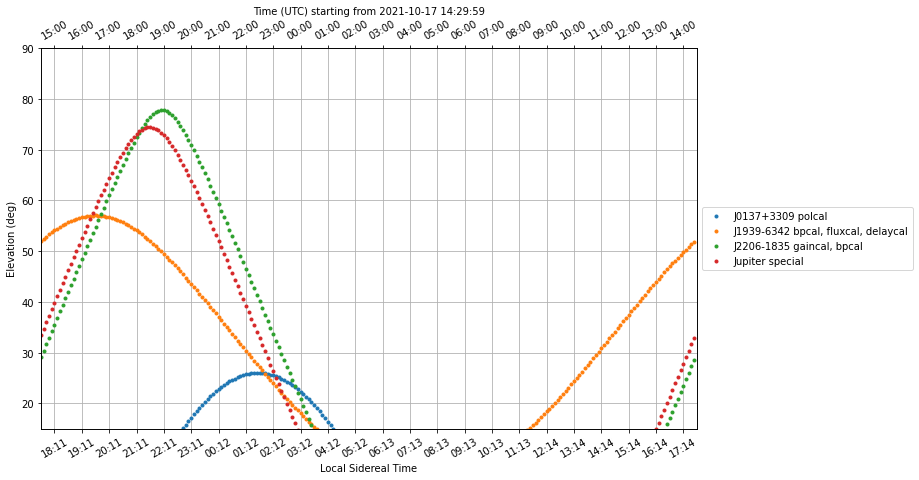

In [99]:
source_elevation(catalogue, ref_antenna)
plt.savefig('elevation.png')
plt.show()

```
configure_obs()
obs.sb.new(owner="ruby")
obs.sb.type=katuilib.ScheduleBlockTypes.OBSERVATION
obs.sb.description="Atmospheric OH: Callisto/Jovian"
obs.sb.antenna_spec="available"
obs.sb.controlled_resources_spec="cbf,sdp"
obs.sb.instruction_set="run-obs-script /home/kat/katsdpscripts/observation/image.py /home/kat/katsdpcatalogues/jupiter_callisto.csv -t 904 -g 128 -b 296 -i 3600 -m 28800"
obs.sb.proposal_id="SSV-2021????-??-01"
obs.sb.horizon=15.0
obs.sb.desired_start_time='2021-08-27 18:00'
obs.sb.desired_start_time='2021-09-12 17:00'
obs.sb.desired_start_time='2021-09-29 16:00'
obs.sb.desired_start_time='2021-10-16 14:30'
obs.sb.to_defined()
obs.sb.to_approved()
obs.sb.unload()
```